# Flow duration curve on US map
  
  In this excercise, you will create an interactive map that shows flow duration curve for 671 catchments in US. This example uses CAMELS dataset (https://ral.ucar.edu/solutions/products/camels) $^{1,2}$. You will also examine the spatial pattern of a characteristic of the flow duration curve and examine correlation between the characteristic and other variables.
    
  
  1. A. Newman; K. Sampson; M. P. Clark; A. Bock; R. J. Viger; D. Blodgett, 2014. A large-sample watershed-scale hydrometeorological dataset for the contiguous USA. Boulder, CO: UCAR/NCAR. https://dx.doi.org/10.5065/D6MW2F4D
  
  2. A. J. Newman, M. P. Clark, K. Sampson, A. Wood, L. E. Hay, A. Bock, R. J. Viger, D. Blodgett, L. Brekke, J. R. Arnold, T. Hopson, and Q. Duan: Development of a large-sample watershed-scale hydrometeorological dataset for the contiguous USA: dataset characteristics and assessment of regional variability in hydrologic model performance. Hydrol. Earth Syst. Sci., 19, 209-223, doi:10.5194/hess-19-209-2015, 2015

# 1. US map and catchment boundaries

    
We will first create the US map with the catchment boundary for 671 catchments. The python code in the below box will do the job for you. Click the below box and press Shift+Enter to run the code. Wait until you see the map. The cathment boundaries are illustarted with the blue lines in the map. Navigate around the map to see what catchments are included in the CAMELS dataset.

In [108]:
from ipyleaflet import Map, ZoomControl, Marker, Popup, GeoJSON, WidgetControl, basemaps, Choropleth
import json

m = Map(basemap=basemaps.Esri.WorldTopoMap, zoom=4, center=[31.64 + 3 + 3, -76.52 - 5 - 5], zoom_control=False)  # Do not automatically create a ZoomControl
m.add_control(ZoomControl(position='topright'))


with open('./HCDN_nhru_final_671_Features2_simplified.json','r') as f:
    catchments = json.load(f)

geo = GeoJSON(data=catchments, style={'fillColor': 'white', 'weight': 0.5}, hover_style={'fillColor': '#1f77b4'}, name='Catchments')
m.add_layer(geo)

m

Map(center=[37.64, -86.52], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright…

# 2. Flow duration curve module

Now, we will define a function that retunrs the flow duration curve. The function receives discharge data and a logical flag to determine whether to normalize the flow duration curve or not. (Note that the following code does not give you any result after you run the code. We are just defining the function to use it later.) If you are familiar with a programming langauge, please try to interpret the code. If you are not, just run the code.
    
    
   #### How to calculate the flow duration curve?
        
&emsp;Step 1: Sort (rank) average daily discharges for period of record from the largest value to the smallest value, involving a total of n values.

&emsp;Step 2: Assign each discharge value a rank ($M$), starting with 1 for the largest daily discharge value.

&emsp;Step 3: Calculate exceedence probability ($P$) as follows:

<br>

&emsp;&emsp;&emsp;&emsp;$P =  M / (n + 1) $

<br>

&emsp;&emsp;$P$: the probability that a given flow will be equaled or exceeded (dimensionless)

&emsp;&emsp;$M$: the ranked position on the listing (dimensionless)

&emsp;&emsp;$n$: the number of events for the period of record (dimensionless)


In [116]:
import numpy as np

def FDC(Qobs, norm = True):
    tot_time_length = len(Qobs)
    temp = Qobs.argsort()
    temp = np.flipud(temp)
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(tot_time_length)
    ranks = ranks + 1
    if norm:
        Qmean = np.nanmean(Qobs)
        Qnorm = Qobs / Qmean
    else:
        Qnorm = Qobs
        
    ranknorm = ranks/(np.float(tot_time_length) + 1)

# Sort ranknorm and Qnorm based on ranknorm

    temp = ranknorm.argsort()
    Qnorm = Qnorm[temp]
    ranknorm = ranknorm[temp]
    
    

    return Qnorm, ranknorm

# 3. Create interactive figure

This part is to creat an interactive figure that we will overlay in the map. If you are not intrested in learning how to generate an interactive plot for the map, just run the code and go to "4. Overlay the figure on the map". When the code runs, it will plot a flow duartion curve for the catchment with its ID of 12043000. Also, please note that 'flag_norm' determines whether to normalize discharge or not. When it is 'True' the discharge data will be nomalized by its mean $Q_m$.
    

In [117]:
from bqplot import Lines, Figure, LinearScale, DateScale, Axis, LogScale
import pandas as pd


catchment_id = '12043000'
flag_norm = False

catchment_id_here = catchment_id
if len(catchment_id_here) == 7:
    catchment_id_here = '0' + catchment_id_here

filename=  './data/' + catchment_id_here + '_streamflow_qc.txt'
import zipfile
with zipfile.ZipFile('data2.zip') as z:
   with z.open(catchment_id_here + '_streamflow_qc.txt') as f:
        data = pd.read_csv(f, delim_whitespace=True , header = None) 

data.columns = ['ID','YEAR','MONTH','DAY','Q','QC']
Qhere = data.Q.values[data.Q.values>-999]
fdc_y, fdc_x = FDC(Qhere, norm = flag_norm)
    
    
x_scale = LinearScale(min = 0.00, max = 1.0)
if flag_norm:
    y_scale = LogScale(min = 0.02,max=20.0)
else:
    y_scale = LogScale(min = np.nanmin(Qhere)*0.8,max=np.nanmax(Qhere)*1.2)
    
lines = Lines(x=fdc_x, y=fdc_y, scales={'x': x_scale, 'y': y_scale})

ax_x = Axis(label='Exceedance Prob. [-]', scale=x_scale, xlim = (0.1), tick_values = [0.0,0.2,0.4,0.6,0.8,1])
if flag_norm:
    ax_y = Axis(label='Q/Qm [-]', scale=y_scale, orientation='vertical', side='left')
else:
    ax_y = Axis(label='Q [cfs]', scale=y_scale, orientation='vertical', side='left')

    
figure = Figure(axes=[ax_x, ax_y], title=country_name, marks = [lines], animation_duration=500,
                layout={'max_height': '250px', 'max_width': '400px'})

figure

Figure(animation_duration=500, axes=[Axis(label='Exceedance Prob. [-]', scale=LinearScale(max=1.0, min=0.0), t…

# 4. Overlay the figure on the map

We now describe how to overlay the figure on the map. Again, if you are not interested in technical details, countinue to the next point.

In [118]:
def update_figure(catchment_id, data_name):
# Load file
    catchment_id_here = catchment_id
    if len(catchment_id_here) == 7:
        catchment_id_here = '0' + catchment_id_here
        
    filename=  './data/' + catchment_id_here + '_streamflow_qc.txt'
    filename

    import pandas as pd

    with zipfile.ZipFile('data2.zip') as z:
       with z.open(catchment_id_here + '_streamflow_qc.txt') as f:
            data = pd.read_csv(f, delim_whitespace=True , header = None) 
    
    data.columns = ['ID','YEAR','MONTH','DAY','Q','QC']
    Qhere = data.Q.values[data.Q.values>-999]    
    fdc_y, fdc_x = FDC(Qhere, norm = flag_norm)
    
    lines_x = fdc_x
    lines.y = fdc_y
    if flag_norm == False:
        y_scale = LogScale(min = np.nanmin(Qhere)*0.8,max=np.nanmax(Qhere)*1.2)
#        tick_values_set = []
        ax_y = Axis(label='Q [cfs]', scale=y_scale, orientation='vertical', side='left') #, tick_values = tick_values_set)

    figure.axes = [ax_x,ax_y]
    figure.title = catchment_id
    
widget_control1 = WidgetControl(widget=figure, position='bottomright')

m.add_control(widget_control1)

def on_hover(event, feature, **kwargs):
    global catchment_id

    catchment_id = str(feature['properties']['hru_id'])
    update_figure(catchment_id, data_name)

geo.on_hover(on_hover)

# 5. Interactive map

Let's generate an interactive map that shows the flow duration curve of a catchment you hover on. Run the following code, and navigate around! Do you see the difference between catchments?

In [112]:
m

Map(bottom=1785.0, center=[37.64, -86.52], controls=(AttributionControl(options=['position', 'prefix'], positi…

# 6. Spatial pattern of the flow duartion curve

Let's examine a spatial patter of a characteristic of the flow duration curve. We will use a slope of the flow duartion curve between 0.3 and 0.7 exceedance probability. We will create a choropleth map that shows the slope over the catchment.
The CAMELS dataset includes the estimated slope. So, let's read the dataset first instead of calculating the slope by ourselves. In the following code, we will read the CAMELS HYDRO data. Run the code, and it will show you a table of the data.

In [113]:
camels_hydro = pd.read_csv('./camels_hydro.txt', delimiter = ';')
camels_hydro[np.isnan(camels_hydro)] = -9999.

camels_hydro

,gauge_id,q_mean,runoff_ratio,slope_fdc,baseflow_index,stream_elas,q5,q95,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,hfd_mean
0,1013500,1.699155,0.543437,1.528219,0.585226,1.845324,0.241106,6.373021,6.10,8.714286,41.35,20.170732,0.000000,207.25
1,1022500,2.173062,0.602269,1.776280,0.554478,1.702782,0.204734,7.123049,3.90,2.294118,65.15,17.144737,0.000000,166.25
2,1030500,1.820108,0.555859,1.871110,0.508441,1.377505,0.107149,6.854887,12.25,7.205882,89.25,19.402174,0.000000,184.90
3,1031500,2.030242,0.576289,1.494019,0.445091,1.648693,0.111345,8.010503,18.90,3.286957,94.80,14.697674,0.000000,181.00
4,1047000,2.182870,0.656868,1.415939,0.473465,1.510238,0.196458,8.095148,14.95,2.577586,71.55,12.776786,0.000000,184.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,14309500,2.457700,0.493734,1.689890,0.459455,1.220096,0.057651,10.203129,41.10,4.835294,165.55,41.911392,0.000000,125.55
667,14316700,2.925937,0.643997,2.231023,0.508616,1.552484,0.141493,10.653569,16.15,2.543307,136.40,33.679012,0.000000,135.50
668,14325000,4.072283,0.646657,2.246135,0.480769,1.127976,0.104916,15.891946,23.80,3.216216,153.35,47.921875,0.000000,125.90
669,14362250,0.332015,0.119358,1.186040,0.518408,2.694495,0.000000,1.358552,33.55,9.867647,148.05,32.538462,0.088296,138.05


Now you will create the Choropleth map. The following code generate a Choropleth layer and will show you a colorbar.

In [114]:
from branca.colormap import linear
import branca.colormap as cmp

camels_hydro_dict = dict(zip(camels_hydro.index,(camels_hydro['slope_fdc']).tolist()))
cmap2 = cmp.LinearColormap(
    ['yellow', 'green', 'purple'],
    vmin=0.0, vmax=2.5,
#    caption='Color Scale for Map' #Caption for Color scale or Legend
)

layer = Choropleth(
    geo_data=catchments,
    choro_data=camels_hydro_dict,
    value_min = 0.0,
    value_max = 2.5,
    colormap=cmap2,
    border_color='black',
    style={'fillOpacity': 0.9})

cmap2

Now let's create the Choropleth map. Do you see any spatial pattern? If then can you think of any reason why you see the pattern?

In [115]:
m2 = Map(zoom=4, center=[31.64 + 3 + 3, -76.52 - 5 - 5], zoom_control=False)  # Do not automatically create a ZoomControl
m2.add_control(ZoomControl(position='topright'))
m2.add_layer(layer)
m2

Map(center=[37.64, -86.52], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright…

# 7. Relationship between the FDC slope and catchment characteristics

Let's examine if there is any relationship between the FDC slope and catchment characteristics. We will use hydrologic, climatic, topographic, and soil properties. Let's check if we can see any relationship between the baseflow index and the FDC slope.

<br>

The following code will generate a plot which shows a topographic characteristic vs. the slope. It is set to use the 'baseflow index' as the topographic characteristic. Let's run the code, and see if there is a relationship. You can examine a relationship with another characteristic by replacing 'baseflow_index' with other column names in the above table.

Text(0.5, 0, 'Baseflow index [-]')

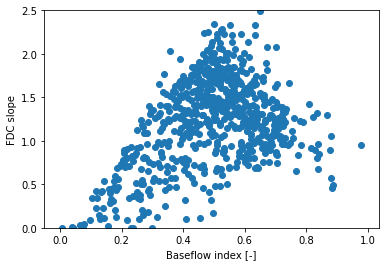

In [45]:
import matplotlib.pyplot as plt
plt.scatter(camels_hydro['baseflow_index'],camels_hydro['slope_fdc'])
plt.ylim([0,2.5])
plt.ylabel('FDC slope')
plt.xlabel('Baseflow index [-]')

Also, let's examine the relationship with other characteristics. We will first read the climate data in the CAMELS dataset.

In [43]:
camels_climate = pd.read_csv('./camels_clim.txt', delimiter = ';')
#camels_climate[np.isnan(camels_climate)] = -9999.

camels_climate

,gauge_id,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,high_prec_timing,low_prec_freq,low_prec_dur,low_prec_timing
0,1013500,3.126679,1.971555,0.187940,0.313440,0.630559,12.95,1.348958,son,202.20,3.427119,mam
1,1022500,3.608126,2.119256,-0.114530,0.245259,0.587356,20.55,1.205279,son,233.65,3.662226,jja
2,1030500,3.274405,2.043594,0.047358,0.277018,0.624111,17.15,1.207746,son,215.60,3.514262,djf
3,1031500,3.522957,2.071324,0.104091,0.291836,0.587950,18.90,1.148936,son,227.35,3.473644,djf
4,1047000,3.323146,2.090024,0.147776,0.280118,0.628929,20.10,1.165217,son,235.90,3.691706,djf
...,...,...,...,...,...,...,...,...,...,...,...,...
666,14309500,4.977781,3.122204,-0.995847,0.061255,0.627228,15.10,1.776471,djf,222.65,6.893189,jja
667,14316700,4.543400,2.277630,-0.821172,0.176337,0.501305,14.75,1.446078,djf,214.85,6.018207,jja
668,14325000,6.297437,2.434652,-0.952055,0.030203,0.386610,14.60,1.467337,djf,219.05,6.240741,jja
669,14362250,2.781676,3.325188,-0.985486,0.141500,1.195390,20.45,1.786026,djf,260.35,7.354520,jja


Let's first examine if the FDC slope and the aridity is related. Do you see any relationship? If then, can you think of any reason why? Again, you can examine the relationship with other variables by replacing "aridity" with other column names.

Text(0.5, 0, 'Aridity [-]')

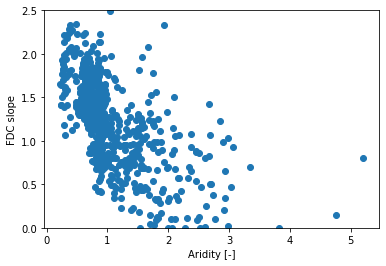

In [18]:
plt.scatter(camels_climate['aridity'],camels_hydro['slope_fdc'])
plt.ylim([0,2.5])
plt.ylabel('FDC slope')
plt.xlabel('Aridity [-]')

The following code reads the topograhic characteristics and the soil characteristics. Please take your time and try to find any relationship.

In [19]:
camels_topo = pd.read_csv('./camels_topo.txt', delimiter = ';')
camels_topo[np.isnan(camels_topo)] = -9999.

camels_topo

,gauge_id,gauge_lat,gauge_lon,elev_mean,slope_mean,area_gages2,area_geospa_fabric
0,1013500,47.23739,-68.58264,250.31,21.64152,2252.70,2303.95
1,1022500,44.60797,-67.93524,92.68,17.79072,573.60,620.38
2,1030500,45.50097,-68.30596,143.80,12.79195,3676.17,3676.09
3,1031500,45.17501,-69.31470,247.80,29.56035,769.05,766.53
4,1047000,44.86920,-69.95510,310.38,49.92122,909.10,904.94
...,...,...,...,...,...,...,...
666,14309500,42.80400,-123.61091,709.83,110.42527,224.92,226.31
667,14316700,43.34984,-122.72894,952.26,119.08920,587.90,588.01
668,14325000,42.89150,-124.07065,656.53,124.96889,443.07,444.92
669,14362250,42.15401,-123.07532,875.67,109.93127,41.42,43.88


Text(0.5, 0, 'Gauge lon.')

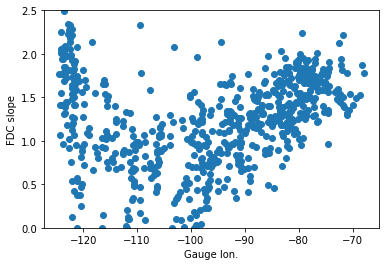

In [20]:
plt.scatter(camels_topo['gauge_lon'],camels_hydro['slope_fdc'])
plt.ylim([0,2.5])
plt.ylabel('FDC slope')
plt.xlabel('Gauge lon.')

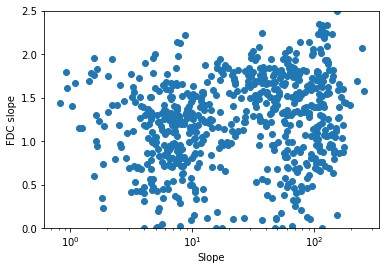

In [26]:
plt.scatter(camels_topo['slope_mean'],camels_hydro['slope_fdc'])
plt.ylim([0,2.5])
plt.ylabel('FDC slope')
plt.xlabel('Slope')
plt.xscale('log')

In [21]:
camels_soil = pd.read_csv('./camels_soil.txt', delimiter = ';')
camels_soil[np.isnan(camels_soil)] = -9999.

camels_soil

,gauge_id,soil_depth_pelletier,soil_depth_statsgo,soil_porosity,soil_conductivity,max_water_content,sand_frac,silt_frac,clay_frac,water_frac,organic_frac,other_frac
0,1013500,7.404762,1.248408,0.461149,1.106522,0.558055,27.841827,55.156940,16.275732,5.376698,0.408717,0.000000
1,1022500,17.412808,1.491846,0.415905,2.375005,0.626229,59.390156,28.080937,12.037646,1.226913,0.000000,0.358472
2,1030500,19.011414,1.461363,0.459091,1.289807,0.653020,32.235458,51.779182,14.776824,1.634345,1.330278,0.022016
3,1031500,7.252557,1.279047,0.450236,1.373292,0.559123,35.269030,50.841232,12.654125,0.674594,0.000000,0.000000
4,1047000,5.359655,1.392779,0.422749,2.615154,0.561181,55.163133,34.185443,10.303622,0.000000,0.000000,0.147867
...,...,...,...,...,...,...,...,...,...,...,...,...
666,14309500,0.894595,0.894531,0.442804,1.335304,0.395703,37.751217,38.879406,23.213862,0.000000,0.000000,0.000000
667,14316700,0.879292,1.340004,0.443107,1.288301,0.584644,37.238495,38.519396,24.363634,0.000000,0.000000,0.000000
668,14325000,0.990318,0.892189,0.442249,1.425770,0.388650,38.961578,40.860260,20.068726,0.000000,0.000000,0.000000
669,14362250,0.625000,0.800111,0.442872,1.363910,0.348779,37.914394,39.602460,22.404372,0.000000,0.000000,0.000000


Text(0.5, 0, 'Silt frac. [%]')

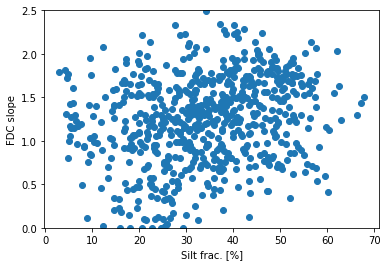

In [22]:
plt.scatter(camels_soil['silt_frac'],camels_hydro['slope_fdc'])
plt.ylim([0,2.5])
plt.ylabel('FDC slope')
plt.xlabel('Silt frac. [%]')